### Usage
This notebook shows how we calculated the NODF Nestedness of our network, using the NestednessCalculator class, and then how we compared the results with the adjacency matrix and the centrality measures ranking.

#### Importing Libraries

In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

from centrality import *

#### Class for Computing the NODF Nestedness

In [3]:
class NestednessCalculator(object):
    """Calculates the nestedness of the input matrix.

    The algorithms that have been implemented are:
        - NODF (Nestedness based on Overlap and Decreasing Fill)
    """

    def __init__(self, mat):
        """Initialize the Nestedness calculator and check the input matrix.

        :param mat: binary input matrix
        :type mat: numpy.array
        """
        self.check_input_matrix_is_binary(mat)
        self.check_degrees(mat)

    @staticmethod
    def check_input_matrix_is_binary(mat):
        """Check that the input matrix is binary, i.e. entries are 0 or 1.

        :param mat: binary input matrix
        :type mat: numpy.array

        :raise AssertionError: raise an error if the input matrix is not
            binary
        """
        assert np.all(np.logical_or(mat == 0, mat == 1)), "Input matrix is not binary."

    @staticmethod
    def check_degrees(mat):
        """Check that rows and columns are not completely zero.

        :param mat: binary input matrix
        :type mat: numpy.array

        :raise AssertionError: raise an error if the input matrix has
            completely zero rows or columns.
        """
        assert np.all(mat.sum(axis=1) != 0), "Input matrix rows with only zeros, abort."
        assert np.all(
            mat.sum(axis=0) != 0
        ), "Input matrix columns with only zeros, abort."

    ################################################################################
    # NODF - Nestedness based on Overlap and Decreasing Fill
    ################################################################################

    @staticmethod
    def get_paired_nestedness(mat, rows=True):
        """Calculate the paired nestedness along the rows or columns of the matrix.

        :param mat: binary input matrix
        :type mat: numpy.array
        :param rows: if True, pairs are calculated along the rows, if False
            along the columns
        :type rows: bool

        :returns: degree of paired nestedness
        :rtype: float
        """
        if rows:
            # consider rows
            po_mat = np.dot(mat, mat.T)
            degrees = mat.sum(axis=1)
        else:
            # consider cols
            po_mat = np.dot(mat.T, mat)
            degrees = mat.sum(axis=0)
        assert len(degrees) == len(po_mat)

        neg_delta = degrees != degrees[:, np.newaxis]
        deg_matrix = degrees * np.ones_like(po_mat)
        deg_minima = np.minimum(deg_matrix, deg_matrix.T)
        n_pairs = po_mat[neg_delta] / (2.0 * deg_minima[neg_delta])
        return n_pairs.sum()

    def nodf(self, mat):
        """Calculate the NODF nestedness of the input matrix.

        :param mat: binary input matrix
        :type mat: numpy.array

        :returns: NODF nestedness of the input matrix
        :rtype: float
        """
        n_pairs_rows = self.get_paired_nestedness(mat, rows=True)
        n_pairs_cols = self.get_paired_nestedness(mat, rows=False)
        norm = np.sum(np.array(mat.shape) * (np.array(mat.shape) - 1) / 2.0)
        nodf = (n_pairs_rows + n_pairs_cols) / norm
        return nodf

#### Loading the Liquidity Graph

In [4]:
def build_graph():
    """Build a graph from the 'top_1000_by_liquidity.csv' file, but without the weights since we want to calculate the nestedness.

    :returns: The built network
    :rtype: nx.Graph
    """
    df = pd.read_csv('top_1000_by_liquidity.csv')
    edges = pd.DataFrame(
    {
        "source": df["token0.symbol"],
        "target": df["token1.symbol"]
    }
    )
    G = nx.from_pandas_edgelist(edges, create_using=nx.Graph().to_undirected())
    return G

G = build_graph()

#### Functions for computing the NODF nestedness for the Input Graph and it's corresponding Null Model

In [5]:
def calculate_nodf(G):
    """Calculates the NODF nestedness of the given graph G.

    :returns: The nestedness of the graph
    :rtype: float
    """
    adj = nx.to_numpy_array(G)
    calculator = NestednessCalculator(adj)
    nodf = calculator.nodf(adj)
    return nodf

In [6]:
def create_null_model(G, iter):
    """Creates a null model by randomizing the given graph G and preserving the degree distribution.

    :returns: The randomized graph
    :rtype: nx.Graph
    """
    G_rand = nx.algorithms.smallworld.random_reference(
        G, niter=iter, connectivity=False
    )
    return G_rand

In [7]:
def calculate_nodf_N_null_models(G, N, iter):
    """Calculates the average nodf of the N null models

    :returns: The average nodf
    :rtype: float
    """
    sum_nodf = 0
    for i in range(N):
        G_rand = nx.algorithms.smallworld.random_reference(
            G, niter=iter, connectivity=False
        )
        G_rand_nodf = calculate_nodf(G_rand)
        sum_nodf += G_rand_nodf
    return sum_nodf / N



In [8]:
G_nestedness = calculate_nodf(G)
G_rand_nestedness = calculate_nodf(create_null_model(G, iter=100))

print(f"Nestedness for G: {G_nestedness}")
print(f"Nestedness for randomised G: {G_rand_nestedness}")


Nestedness for G: 0.09300890661437522
Nestedness for randomised G: 0.12212716691925575


In [16]:
# TODO: randomize 100 graphs - take the avergae of the nestedness and then compare
G_N_rand_nodf = calculate_nodf_N_null_models(G, 10, 100)
print(G_N_rand_nodf)

0.11699778486203109


## Validation of the NODF Nestedness

### 1) Visualization of the Adjacency Matrix

We first need to sort the nodes based on their degree.

In [9]:
G_nodes_sorted = sorted(G.degree, key=lambda x: x[1], reverse=True)
print(G_nodes_sorted)
g_degrees = G.degree()
degrees = [ g_degrees[i] for i in G.nodes()]
node_order = [i[0] for i in G_nodes_sorted]


[('WETH', 763), ('USDC', 86), ('USDT', 52), ('DAI', 14), ('MYTH', 7), ('ACR', 6), ('UETH', 5), ('ROOT', 4), ('VOW', 4), ('WBTC', 4), ('USD', 4), ('TSUKA', 4), ('REQ', 4), ('X7005', 4), ('X7002', 4), ('X7101', 4), ('X7105', 4), ('X7004', 4), ('X7102', 4), ('X7103', 4), ('X7104', 4), ('wPE', 3), ('HEZ', 3), ('DFI', 3), ('GLM', 3), ('HEX', 3), ('XCAD', 3), ('TKX', 3), ('DUCK', 3), ('X7003', 3), ('X7001', 3), ('PAXG', 2), ('ETH2POS', 2), ('DC', 2), ('FXS', 2), ('FRAX', 2), ('HANU', 2), ('BigSB', 2), ('FLX', 2), ('DG', 2), ('WOO', 2), ('AMPL', 2), ('DOGE', 2), ('SAND', 2), ('XFIT', 2), ('INU', 2), ('HDRN', 2), ('RACA', 2), ('SHARE', 2), ('DAO', 2), ('ALBT', 2), ('ZENI', 2), ('CIV', 2), ('SANI', 2), ('MUSK', 2), ('REVV', 2), ('AGIX', 2), ('ALD', 2), ('SYLO', 2), ('CHSB', 2), ('PROS', 2), ('VS', 2), ('BLZ', 2), ('GMEE', 2), ('0NE', 2), ('UNI-V2', 2), ('MAP', 2), ('COT', 2), ('HXRO', 2), ('ANB', 2), ('DDIM', 2), ('ALICE', 2), ('FIS', 2), ('TAIL', 2), ('PRE', 2), ('ULCK', 1), ('WISE', 1), ('DEL

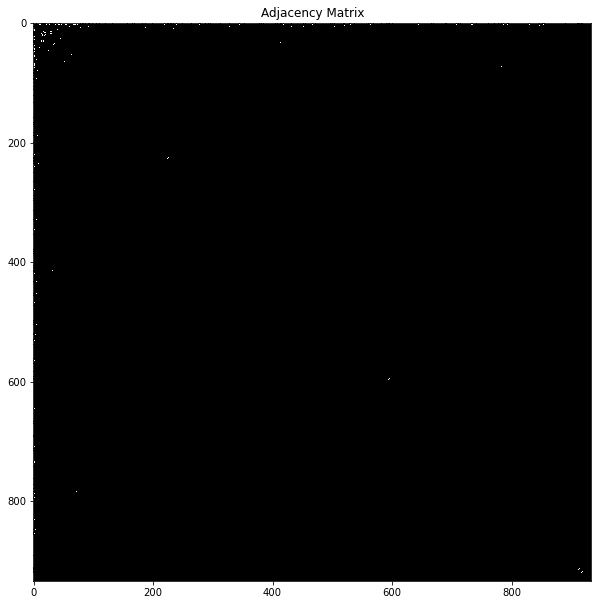

In [14]:
adj = nx.to_numpy_matrix(G, dtype=np.int64, nodelist=node_order)
fig, ax = plt.subplots(figsize=(10,15)) 
plt.imshow(adj, interpolation="nearest", cmap='gray')
plt.title("Adjacency Matrix")
plt.show()
#fig.savefig("adjmatrix_gray.pdf", format="pdf")

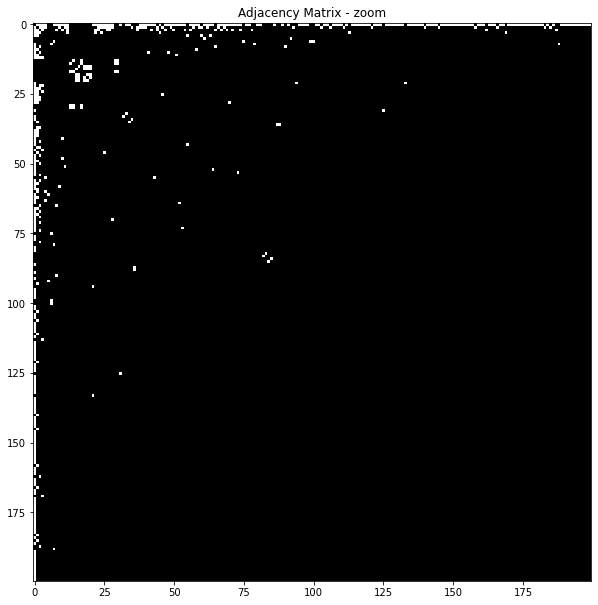

In [15]:
# ZOOM IN
M = adj[:200,:200] 
fig, ax = plt.subplots(figsize=(10,15)) 
plt.imshow(M, interpolation="nearest", cmap='gray')
plt.title("Adjacency Matrix - zoom")
plt.show()
#fig.savefig("adjmatrix_gray_zoom.pdf", format="pdf")

### 2) Check if all the centrality measures are ranked in the same way

To check this we are going to use the Spearman rank coefficient.

In [125]:
sorted_centrality_list = centrality_properties()
sorted_centrality_list

,deg_cent,betw_cent,closeness_cent,eigen_cent
WETH,0.817792,0.889173,0.826662,0.705202
USDC,0.092176,0.122840,0.492449,0.052105
USDT,0.055734,0.064430,0.481828,0.046791
DAI,0.015005,0.014453,0.471395,0.033412
MYTH,0.007503,0.006148,0.460652,0.028522
...,...,...,...,...
USDI,0.001072,0.000000,0.443101,0.025438
LOOT,0.001072,0.000000,0.443101,0.025438
ETH2x-FLI,0.001072,0.000000,0.443101,0.025438
POLC,0.001072,0.000000,0.443101,0.025438


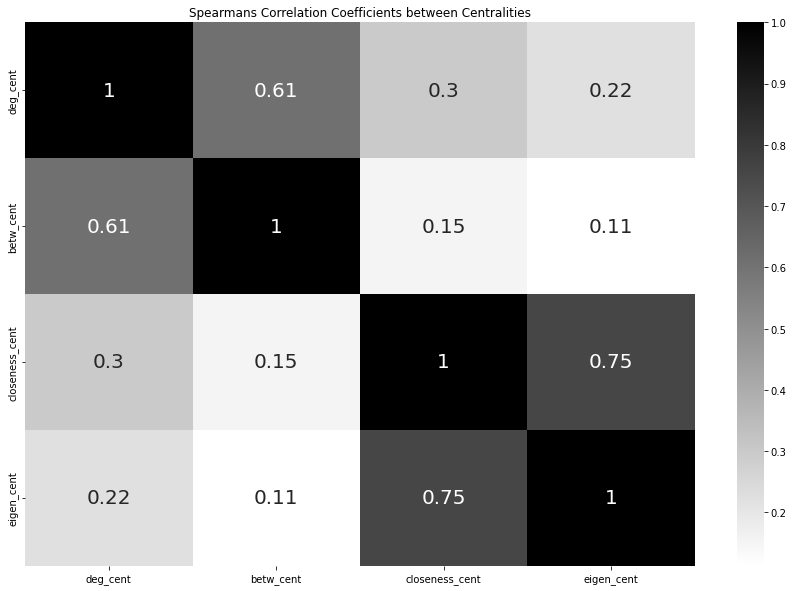

In [128]:
df=sorted_centrality_list
fig, ax = plt.subplots(figsize=(15,10))   
corr = df.corr(method = 'spearman')
sns.heatmap(corr, annot = True, cmap="binary", annot_kws={'size': 20})
plt.title("Spearman's Correlation Coefficients between Centralities")
#fig.savefig("corr_heatmap.pdf", format="pdf")